# Sentiment analysis Part 2
---
<b>MADS-DL Portfolio-Exam Part 2<br>
<b>Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data preparation](#data-prep) <br>
    - [1.1 Preprocessing](#preproc)<br>
- [2. Network Analysis](#network) <br>
    - [2.1. Clean the POSs](#clean_pos) <br>
    - [2.2. Create Nodes and Edges](#node_edge)<br>
    - [2.3. Create Network Graph](#netgraph)<br>
- [3. Twitters POS](#twitter_pos) <br>
- [6. Result](#result)<br>

## Introduction

In the last examination we have performed a sentiment analysis on tweets referring to the infamous #slapgate event during the Oscars on March 27th. For that we have used the Twitter API to obtain the tweets, stored them on a Mongo database, and used different Deep Learning models to extract the intent of each tweet. We have used three models provided by [Hugging Face](https://huggingface.co/) and trained two models ourselves. In this second part we will use the results from last time and analyze the relations between the tweets.

In [1]:
import json
import re
from collections import Counter
from itertools import chain, combinations
from json import JSONDecodeError

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from community import community_louvain
from matplotlib.ticker import PercentFormatter
from pyvis.network import Network
from tqdm.notebook import tqdm

In [2]:
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("ch:s=2.5,rot=.15"))
cmap = sns.color_palette(("ch:s=2.5,rot=.15"), as_cmap=True)

---
<a id='data-prep'></a>

## 1. Data preparation

Similar to last time we will use parquet files to store and load results. 

In [3]:
df = pd.read_parquet("data/slapgate_twitter_mymodel2", engine="pyarrow")

We load the original data stored in our database.

In [4]:
df.iloc[:2, :20]

,_id,reply_settings,conversation_id,source,entities,author_id,context_annotations,created_at,public_metrics,text,lang,possibly_sensitive,referenced_tweets,geo,in_reply_to_user_id,attachments,withheld,emotions_label,emotions_score,more_emotions_label
0,1509190435394277380,everyone,1509190435394277380,Twitter for iPhone,"{'annotations': [{'start': 5, 'end': 9, 'proba...",193318978,"[{'domain': {'id': '118', 'name': 'Award Show'...",2022-03-30 15:26:53+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Will Smith should have been kicked out of the ...,en,False,None,None,NaN,None,None,anger,0.996816,anger
1,1509190219513446407,everyone,1509190219513446407,Twitter for iPhone,"{'annotations': [{'start': 13, 'end': 17, 'pro...",1425906686347419655,"[{'domain': {'id': '118', 'name': 'Award Show'...",2022-03-30 15:26:02+00:00,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Could a Will Smith Roast get bonded or insured...,en,False,None,None,NaN,None,None,joy,0.821839,fear


And also the predicted labels. Again we can see the inconsictencies between the different models. For our further analysis we will use the models predicted by our last model which perfomed the best.

In [5]:
df.iloc[:5, 20:]

,more_emotions_score,spam_label,spam_score,mymodel2_label,mymodel2_score
0,0.668483,LABEL_0,0.934566,joy,0.266241
1,0.685336,LABEL_1,0.580916,surprise,0.841553
2,0.368798,LABEL_1,0.833983,spam,0.746672
3,0.971441,LABEL_0,0.937574,anger,0.723157
4,0.357992,LABEL_1,0.689152,joy,0.268935


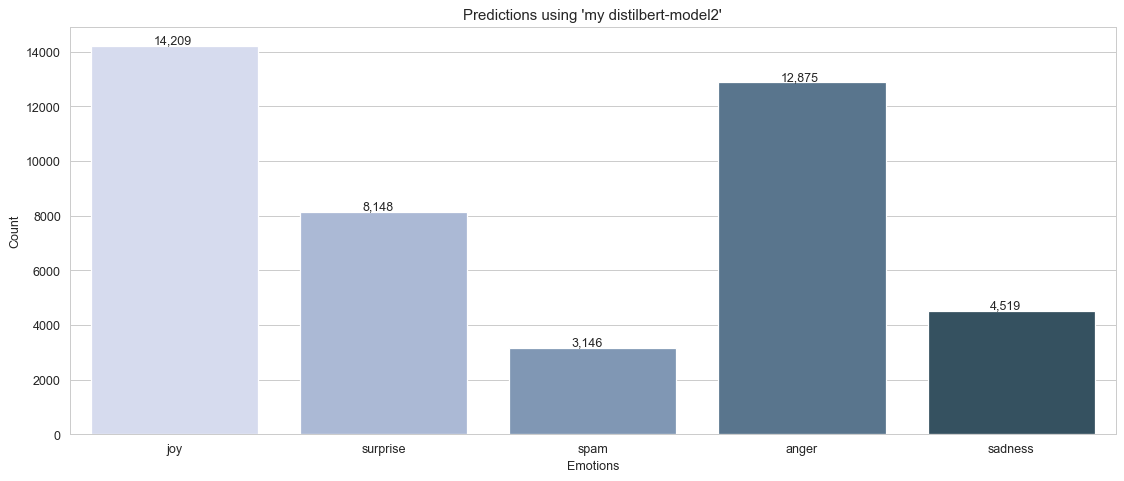

In [6]:
ax = plt.figure(figsize=(15, 6), dpi=90)
ax = sns.countplot(data=df, x="mymodel2_label")
ax.set_xlabel("Emotions")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate("{:>5,d}".format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 100))
ax.xaxis.set_tick_params(which="both", labelleft=True)
ax.set_title("Predictions using 'my distilbert-model2'")
plt.show()

Looking at the distribution of emotions we see that the Twitter users are mostly divided between angry and joyfull. And this coincides with the previous observations of the tweets. Most people were either making jokes about the event or were shocked by the display of violence and lack of direct consequences by the Oscars organisers.

In [7]:
others = df.groupby("source").count().sort_values("_id", ascending=False).index[5:]
df_source = df.replace(others, "Other")
df_src_grp = df_source.groupby(["source", "mymodel2_label"]).count().reset_index().iloc[:, :3]

In [8]:
df_src_grp_sum = df_src_grp.groupby("source").agg(["count", "sum"])
df_src_grp_sum.columns = ["_".join(col) for col in df_src_grp_sum.columns.values]

In [9]:
df_src_grp_t = pd.merge(
    df_src_grp, df_src_grp_sum.reset_index()[["source", "_id_sum"]], on="source"
)
df_src_grp_t["_id_perc"] = df_src_grp_t["_id"] / df_src_grp_t["_id_sum"]

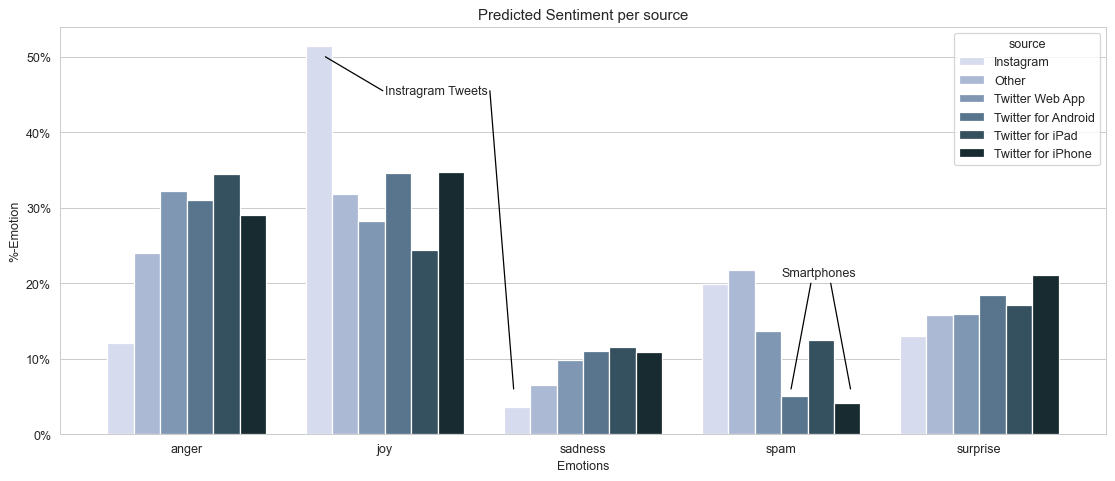

In [10]:
ax = plt.figure(figsize=(15, 6), dpi=90)
ax = sns.barplot(data=df_src_grp_t, x="mymodel2_label", y="_id_perc", hue="source")
ax.set_xlabel("Emotions")
ax.set_ylabel("%-Emotion")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_title("Predicted Sentiment per source")
ax.text(1, 0.45, "Instragram Tweets")
plt.plot([0.7, 0.99], [0.5, 0.455], "k-", lw=1)
plt.plot([1.53, 1.65], [0.455, 0.06], "k-", lw=1)
ax.text(3, 0.21, "Smartphones")
plt.plot([3.15, 3.05], [0.2, 0.06], "k-", lw=1)
plt.plot([3.25, 3.35], [0.2, 0.06], "k-", lw=1)
plt.show()

Looking at the five most used devices we see that most emotions are evenly distributed among the devices. But two types of device sources have interesting results. The first are the tweets that have Instagram as their source. In those cases the user has linked their Instagram account to their Twitter account and can share photos posted on Instagram directly on Twitter. Those tweets are mostly joyful with very few angry or sad posts. This plausible since most of the content posted to Instagram is supposed to be positiv. Unlike Twitter, Instagram is usually not used for negative content and more often used for memes.<br>
The second interesting device source are the Android and iPhone App. Tweets with those devices as source post the least amount of spam tweets. This is also plausible, because most spam accounts use the other Twitter devices. Here, our model also had the highest accuracy.<br>
Staying witht the spam tweets, we can also observe that the Instagram tweets post more spam than the other devices. The reason for this could be, that some of the memes posted to Instagram are identified as spam.

In [11]:
for txt in df[(df["source"] == "Instagram") & (df["mymodel2_label"] == "spam")].sample(2)["text"]:
    print(f"Tweet: {txt}\n")

Tweet: @forbes thank you for another inclusion in today’s online edition !!! #willsmith #chrisrock #oscars #theacademyofmotionpictureartsandsciences https://t.co/ctda0VYhXZ

Tweet: #JeffRoss spoke out in support of #ChrisRock. The standup comedian revealed that he cried when he saw #WillSmith slap him at the #Oscars. 

Source @accesshollywood https://t.co/Y12zyNkwzN



<a id='preproc'></a>

### Preprocessing

Before we begin with our network analysis, we repeat the preprocessing steps from last time. For that we will correct two aspects. The first is to identify and remove potential spam accounts and the second is to make the tweets' text more machine readable. For the possible spam accounts we remove accounts that have posted an excessive amount of tweets. Below we can see that we have accounts with more 100 tweets in our short time frame. Although some power users might sent this many tweets, I will remove those frequent posters in an attempt to get rid of possible spam tweets posted by (probably) bots. Below are some example spam-tweets. Those 149 accounts are responsible for ~3.500 tweets. More than half of these tweets have been posted via the Web App, which speaks for a possible bot.

In [12]:
df_grouped = df.groupby("author_id").count().sort_values(by="_id", ascending=False)
spammer_ids = df_grouped[df_grouped["_id"] >= 10].reset_index()["author_id"]

In [13]:
df_nobots = df.drop(df[df["author_id"].isin(spammer_ids)].index, axis=0)

Next we will edit the tweets themselves. Many users have used the special character & which is encoded as & and will be converted to the word and. Additionally we remove all '@' and '#' symbols to make the text more readable. The example below shows how many users use hashtags and @ as part of their speech in the tweets. Therefore, completely removing the hashtags would remove some meaning of the origin text. We also remove all hyperlinks from the tweets because those produce many false positives.

In [14]:
def preproc_tweets(txt: str):
    new_txt = txt.replace("&amp;", "and")
    new_txt = new_txt.replace("@", "")
    new_txt = new_txt.replace("#", "")
    new_txt = re.sub(
        r"(http|https|ftp|ftps)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?", "", new_txt
    )
    return new_txt

In [15]:
df["text"].loc[7763:7764].iloc[0]

'I knew these #Whitesupremacist #Racist who support #NeoNazi,#Nazis,&amp; #Nazism in #Ukraine were going to start saying,#BlackOnBlackCrime with this whole #willsmithchrisrock slap thing. #WillSmith #ChrisRock,#Oscars,#Oscars2022 #EndWhitesupremacy #EndWhiteness'

In [16]:
df["text"].loc[7763:7764].apply(preproc_tweets).iloc[0]

'I knew these Whitesupremacist Racist who support NeoNazi,Nazis,and Nazism in Ukraine were going to start saying,BlackOnBlackCrime with this whole willsmithchrisrock slap thing. WillSmith ChrisRock,Oscars,Oscars2022 EndWhitesupremacy EndWhiteness'

We apply our preprocessing steps on the tweets.

In [17]:
df["text"] = df["text"].apply(preproc_tweets)

---
<a id='network'></a>

## 2. Network Analysis

To create the relationship network we will use Spacy's pretrained NLP pipeline. This pretrained pipeline arleady comes with a part-of-speech (POS) tagger that we will use to identify verbs, adjectives and proper nouns.

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
verbs = list()
adj = list()
propn = list()
for idx in tqdm(range(len(df))):
    _id = df.iloc[idx, :]["conversation_id"]
    doc = nlp(df.iloc[idx, :]["text"])
    for token in doc:
        if token.pos_ == "VERB":
            verbs.append([_id, token.text])
        elif token.pos_ == "ADJ":
            adj.append([_id, token.text])
        elif token.pos_ == "PROPN":
            propn.append([_id, token.text])

  0%|          | 0/42897 [00:00<?, ?it/s]

We create three DataFrames containing the conversation ID and the respective POS tags. Instead of the unique tweet ID we are using the conversation IDs because we want to get the sentiment of conversation.

In [67]:
df_verbs = pd.DataFrame(verbs, columns=["ids", "verbs"])
df_adj = pd.DataFrame(adj, columns=["ids", "adjectives"])
df_propn = pd.DataFrame(propn, columns=["ids", "porper_noun"])

<a id='clean_pos'></a>

### 2.1. Clean the POSs

After we have extracted the verbs, adjectives and proper nouns we must remove some wrongly classified words. One of those misclassifications are tokens starting with ´. In those cases Spacy has wrongly identified the abbreviations of words such as is or not (e.g. haven't or it's).

In [68]:
conditions = (
    df_verbs["verbs"].str.startswith("’")
    | df_verbs["verbs"].str[0].str.isupper()
    | df_verbs["verbs"].str.contains("smith")
    | df_verbs["verbs"].str.contains("chris")
    | df_verbs["verbs"].str.contains("oscar")
    | (df_verbs["verbs"].str.len() <= 2)
)
df_verbs = df_verbs.drop(df_verbs[conditions].index)

In [69]:
conditions = (
    df_adj["adjectives"].str.startswith("’")
    | df_adj["adjectives"].str[0].str.isupper()
    | df_adj["adjectives"].str.contains("smith")
    | df_adj["adjectives"].str.contains("chris")
    | df_adj["adjectives"].str.contains("oscar")
    | (df_adj["adjectives"].str.len() <= 2)
)
df_adj = df_adj.drop(df_adj[conditions].index)

In [70]:
conditions = df_propn["porper_noun"].str.len() <= 2
df_propn = df_propn.drop(df_propn[conditions].index)
df_propn["porper_noun"] = df_propn["porper_noun"].str.lower()

In [71]:
print(
    f"Verbs:        {df_verbs.shape[0]:6,d}\n"
    f"Adjectives:   {df_adj.shape[0]:06,d} \n"
    f"Proper Nouns: {df_propn.shape[0]:6,d}"
)

Verbs:        110,094
Adjectives:   46,027 
Proper Nouns: 190,980


This gives us ~100k entries for verbs, ~46k entries for adjectives and ~190k entries for proper nouns.

<a id='node_edge'></a>

### 2.2. Create Nodes and Edges

Next we create the nodes and edges for the network. 

In [24]:
def create_nodes(df: pd.DataFrame, tag: str, count: int = 100) -> pd.DataFrame:
    _df = df.copy(deep=True)
    nodes = _df.value_counts(tag).reset_index().rename(columns={0: "n"})
    nodes["position"] = nodes["n"].rank(ascending=False).astype(int)
    nodes = nodes[nodes["position"] <= count]
    return nodes

In [25]:
def create_edges(
    df: pd.DataFrame, nodes: pd.DataFrame, tag: str, mention_n: int = 2
) -> pd.DataFrame:
    _df = df.merge(nodes[tag], how="inner", on=tag)
    _df[f"n_{tag}"] = _df.groupby("ids")[tag].transform("count")
    _df = _df[_df[f"n_{tag}"] >= mention_n].reset_index().drop(columns=f"n_{tag}")
    _df[tag] = _df[tag].astype(str)
    _df[tag] = _df.groupby(["ids"])[tag].transform(lambda x: " ".join(x))
    _df = _df.reset_index().drop_duplicates(subset="ids")[["ids", tag]].reset_index(drop=True)
    _df[tag] = _df[tag].map(str.split)

    tag_pairs = [list(combinations(i, 2)) for i in _df[tag]]
    all_tag_pairs = list(chain(*tag_pairs))
    tag_pair_count = Counter(all_tag_pairs)

    edges = pd.DataFrame.from_dict(tag_pair_count, orient="index")
    edges[f"{tag}1"], edges[f"{tag}2"] = zip(*edges.index)
    edges.reset_index(inplace=True, drop=True)
    edges = edges.rename(columns={0: "value"}).sort_values("value", ascending=False)
    cols = [f"{tag}1", f"{tag}2", "value"]
    edges = edges[cols]
    edges = (
        edges.merge(nodes, how="inner", left_on=f"{tag}1", right_on=tag)
        .rename(columns={"n": "source_n"})
        .merge(nodes, how="inner", left_on=f"{tag}2", right_on=tag)
        .rename(columns={"n": "target_n"})
    )

    edges[f"{tag}1_share"] = edges.value / edges.source_n
    edges[f"{tag}2_share"] = edges.value / edges.target_n

    edges = edges.query(f"{tag}1_share>0.05 | {tag}2_share>0.05")
    return edges[[f"{tag}1", f"{tag}2", "value", f"{tag}1_share", f"{tag}2_share"]]

In [26]:
def create_partition(G, tag: str, nodes: pd.DataFrame) -> pd.DataFrame:
    partition = community_louvain.best_partition(G)
    louvain_communities = (
        pd.DataFrame.from_dict(partition, orient="index")
        .reset_index()
        .rename(columns={"index": tag, 0: "louvain"})
    )
    nodes = nodes.merge(louvain_communities, how="inner", on=tag)
    return nodes

In [93]:
tag = "verbs"
verb_nodes = create_nodes(df_verbs, tag, 100)
verb_nodes.head()

,verbs,n,position
0,have,1672,1
1,think,1576,2
2,know,1451,3
3,got,1389,4
4,get,1380,5


The resulting DataFrames then contain the 100 most words for their target with their respective amount and rank. We then remove some verbs that are correct, but will not give us any usefull information regarding the sentiment.

In [89]:
non_words = ["have","think","know","got","get","happened","take","said","made","make","see","did","going","had","say","has","need"]

In [100]:
verb_nodes = verb_nodes[~verb_nodes["verbs"].isin(non_words)]
verb_nodes.shape

(83, 3)

With the remaining 83 words we create the edges.

In [96]:
verb_edges = create_edges(df_verbs, verb_nodes, tag, mention_n=3)
verb_edges.head()

,verbs1,verbs2,value,verbs1_share,verbs2_share
0,assaulted,allowed,91,0.197397,0.335793
1,watch,allowed,53,0.079104,0.195572
2,gets,allowed,25,0.071429,0.092251
3,assault,allowed,62,0.152709,0.228782
4,want,allowed,33,0.050305,0.121771


In [97]:
verb_edges.shape

(488, 5)

For those 83 words we get 488 edges.

<a id='netgraph'></a>

### 2.3. Create Network Graph

Now we create the final network with our nodes and edges. But before that we use the Louvain method to calculate communities.

In [98]:
verb_G = nx.Graph()
for index, row in verb_nodes.iterrows():
    verb_G.add_node(row[tag], nodesize=row["n"])
for index, row in verb_edges.iterrows():
    verb_G.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])
verb_nodes_l = create_partition(verb_G, tag, verb_nodes)
verb_nodes_l

,verbs,n,position,louvain
0,slapped,1347,6,0
1,slap,1160,11,0
2,whatjusthappened,861,20,2
3,slapping,758,21,3
4,hit,729,22,4
...,...,...,...,...
78,hitting,241,96,4
79,deserve,238,97,4
80,knew,233,98,0
81,hear,217,99,9


In [76]:
def draw_graph(G, size, nodes, k=3, iterations=60):
    plt.figure(figsize=size)
    pos = nx.drawing.spring_layout(G, k=k, iterations=iterations)
    node_size = [d["nodesize"] * 0.7 for _, d in G.nodes(data=True)]
    edge_width = [np.sqrt(d["weight"] * 0.05) for _, _, d in G.edges(data=True)]
    cmap = cm.get_cmap("coolwarm", nodes.louvain.nunique())

    # Draw Network
    nx.draw_networkx(
        G,
        pos=pos,
        node_color=nodes.louvain,
        cmap=cmap,
        node_size=node_size,
        width=edge_width,
        edge_color="grey",
        font_size=16,
        alpha=0.8,
    )
    plt.show()

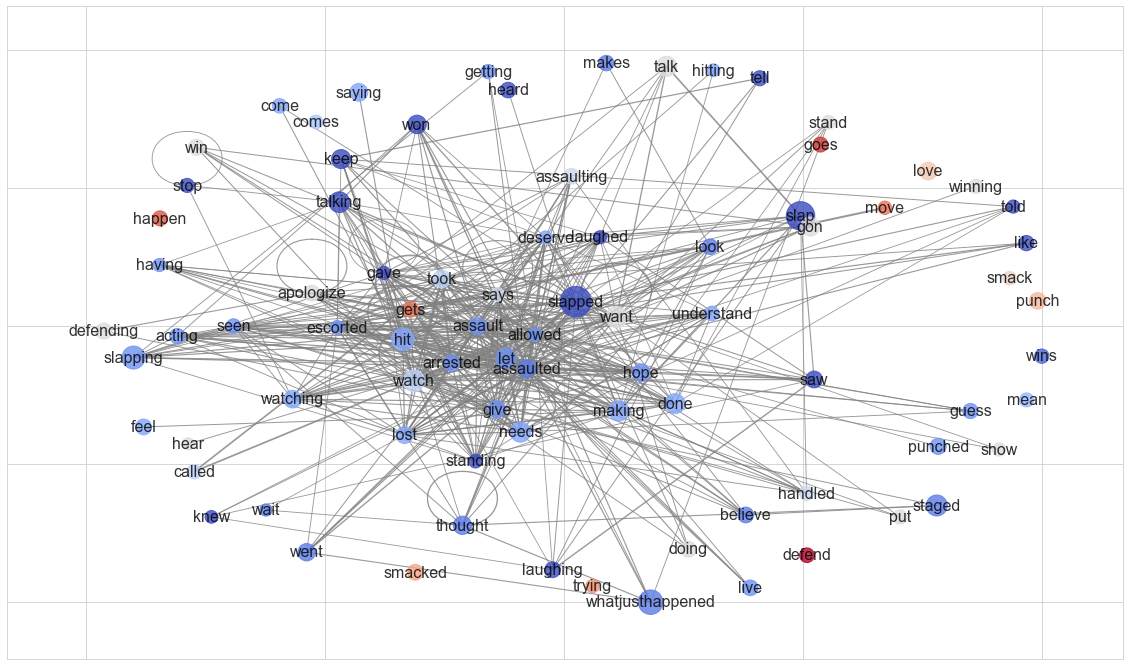

In [99]:
draw_graph(verb_G, size=(20, 12), nodes=verb_nodes_l, k=4, iterations=50)

In [32]:
tag = "adjectives"
adj_nodes = create_nodes(df_adj, tag, 100)
adj_edges = create_edges(df_adj, adj_nodes, tag, 2)
adj_G = nx.Graph()
for index, row in adj_nodes.iterrows():
    adj_G.add_node(row[tag], nodesize=row["n"])
for index, row in adj_edges.iterrows():
    adj_G.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])
adj_nodes_l = create_partition(adj_G, tag, adj_nodes)

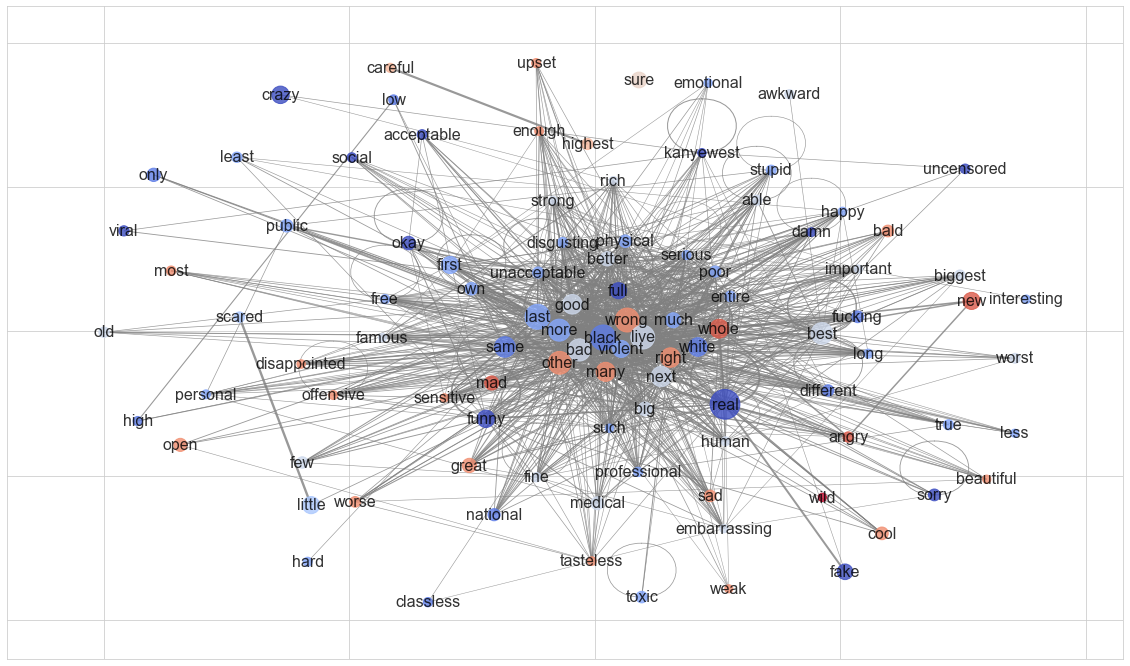

In [33]:
draw_graph(adj_G, size=(20, 12), nodes=adj_nodes_l, k=3, iterations=50)

In [34]:
tag = "porper_noun"
propn_nodes = create_nodes(df_propn, tag, 75)
propn_edges = create_edges(df_propn, propn_nodes, tag, 2)
propn_G = nx.Graph()
for index, row in propn_nodes.iterrows():
    propn_G.add_node(row[tag], nodesize=row["n"])
for index, row in propn_edges.iterrows():
    propn_G.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])
propn_nodes_l = create_partition(propn_G, tag, propn_nodes)

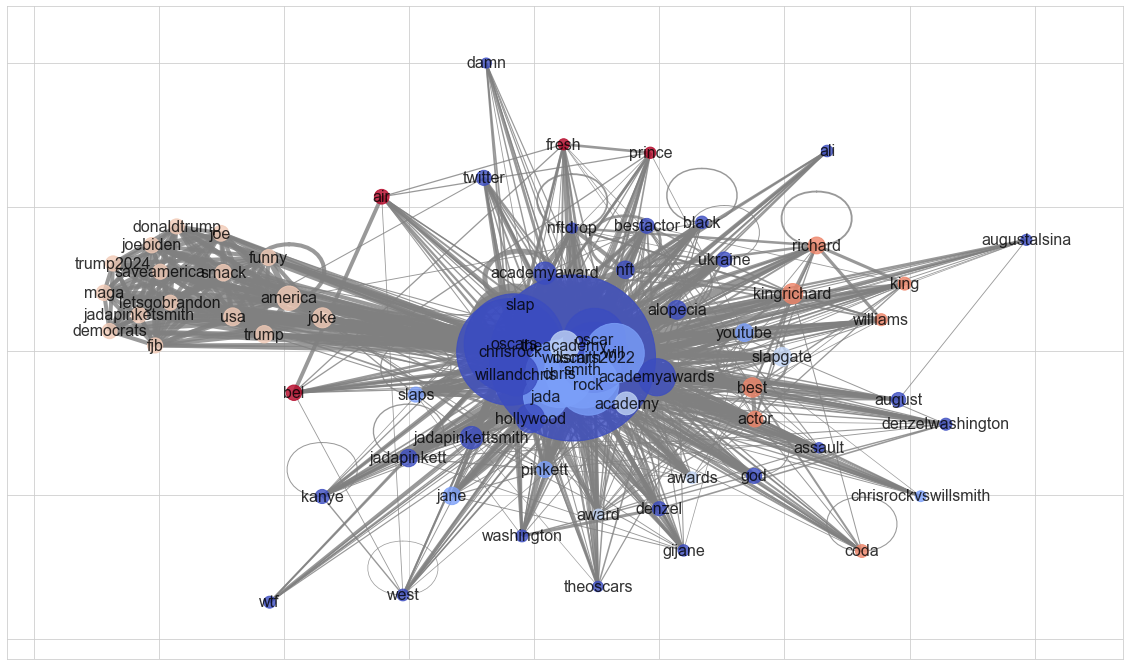

In [35]:
draw_graph(propn_G, size=(20, 12), nodes=propn_nodes_l, k=3, iterations=60)

In [36]:
nt = Network(height="600px", width="1200px", notebook=True)

for index, row in propn_nodes_l.iterrows():
    nt.add_node(
        n_id=row[tag],
        value=row["n"],
        group=row["louvain"],
        shape="dot",
        title=f"Tag: {row[tag]} \n Rank: {row['position']}",
    )
for index, row in propn_edges.iterrows():
    nt.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])

# nt.show_buttons(filter_=["physics"])
nt.barnes_hut(central_gravity=0, spring_length=500, damping=0.2)
nt.set_options(
    """
var options = {
  "physics": {
        "maxVelocity": 10,
        "minVelocity": 0.75},
  "nodes": {"font": {"size": 30}}
}"""
)
nt.show("Slapgate_propn.html")

---
<a id='twitter_pos'></a>

## 3. Twitters POS

In [37]:
def flatten_annotations(row: list, threshold: float = 0.9):
    results = list()
    if not isinstance(row, list):
        return results
    for entry in row:
        if entry["probability"] > threshold:
            results.append([entry["type"], entry["normalized_text"]])
    return results


def flatten_mentions(row: list):
    results = list()
    if not isinstance(row, list):
        return results
    return [entry["username"] for entry in row]

In [38]:
df = pd.read_parquet("data/slapgate_twitter_mymodel2")

In [39]:
counter = 0
bad_rows = list()
for idx, entity in enumerate(df["entities"]):
    entity = entity.replace("'", '"')
    try:
        entity = json.loads(entity)
    except (AttributeError, JSONDecodeError):
        bad_rows.append(idx)
        counter += 1
print(counter)
df = df.drop(df.index[bad_rows])

207


In [40]:
df_entities = pd.json_normalize(df.iloc[:, :]["entities"].str.replace("'", '"').apply(json.loads))
df_entities["annotations"] = df_entities["annotations"].apply(flatten_annotations)
df_entities["mentions"] = df_entities["mentions"].apply(flatten_mentions)

In [41]:
df = pd.merge(
    df,
    df_entities.iloc[:, [0, 3]],
    left_index=True,
    right_index=True,
).drop("entities", axis=1)

In [42]:
annotations = list()
mentions = list()
for idx in tqdm(range(len(df))):
    _id = df.iloc[idx, :]["_id"]
    anns = df.iloc[idx, :]["annotations"]
    annotations += [[_id, an[0], an[1]] for an in anns]
    mens = df.iloc[idx, :]["mentions"]
    mentions += [[_id, men] for men in mens]

  0%|          | 0/42486 [00:00<?, ?it/s]

In [43]:
df_annotations = pd.DataFrame(annotations, columns=["ids", "type", "pnoun"])
df_mentions = pd.DataFrame(mentions, columns=["ids", "mentions"])

In [44]:
df_annotations["type"].value_counts()

Person          11797
Place             679
Other             224
Organization       54
Product            35
Name: type, dtype: int64

In [104]:
tag = "mentions"
mentions_nodes = create_nodes(df_mentions, tag, 75)
mentions_edges = create_edges(df_mentions, mentions_nodes, tag, 2)
mentions_G = nx.Graph()
for index, row in mentions_nodes.iterrows():
    mentions_G.add_node(row[tag], nodesize=row["n"])
for index, row in mentions_edges.iterrows():
    mentions_G.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])
mentions_nodes_l = create_partition(mentions_G, tag, mentions_nodes)

In [105]:
nt = Network(height="600px", width="1200px", notebook=True)

for index, row in mentions_nodes_l.iterrows():
    nt.add_node(
        n_id=row[tag],
        value=row["n"],
        group=row["louvain"],
        shape="dot",
        title=f"Tag: {row[tag]} \n Rank: {row['position']}",
    )
for index, row in mentions_edges.iterrows():
    nt.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])

# nt.show_buttons(filter_=["physics"])
nt.barnes_hut(central_gravity=0, spring_length=500, damping=0.2)
nt.set_options(
    """
var options = {
  "physics": {
        "maxVelocity": 10,
        "minVelocity": 0.75},
  "nodes": {"font": {"size": 30}}
}"""
)
nt.show("Slapgate_mentions.html")

In [106]:
tag = "pnoun"
annotations_nodes = create_nodes(df_annotations, tag, 75)
annotations_edges = create_edges(df_annotations, annotations_nodes, tag, 2)
annotations_G = nx.Graph()
for index, row in annotations_nodes.iterrows():
    annotations_G.add_node(row[tag], nodesize=row["n"])
for index, row in annotations_edges.iterrows():
    annotations_G.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])
annotations_nodes_l = create_partition(annotations_G, tag, annotations_nodes)

In [107]:
nt = Network(height="600px", width="1200px", notebook=True)

for index, row in annotations_nodes_l.iterrows():
    nt.add_node(
        n_id=row[tag],
        value=row["n"],
        group=row["louvain"],
        shape="dot",
        title=f"Tag: {row[tag]} \n Rank: {row['position']}",
    )
for index, row in annotations_edges.iterrows():
    nt.add_edge(row[f"{tag}1"], row[f"{tag}2"], weight=row["value"])

# nt.show_buttons(filter_=["physics"])
nt.barnes_hut(central_gravity=0, spring_length=500, damping=0.2)
nt.set_options(
    """
var options = {
  "physics": {
        "maxVelocity": 10,
        "minVelocity": 0.75},
  "nodes": {"font": {"size": 30}}
}"""
)
nt.show("Slapgate_annotations.html")